In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_fft_cnn import PPO_make_train as PPO_FFT_make_train
from rl_algos.ppo_clipped_normal import PPO_make_train as PPO_Clipped_make_train
from rl_algos.ppo_continuous import PPO_make_train as PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [7]:
## Cairo Params

# Static Physics Params
tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0
shot_noise_std = 0.01
standard_fid = 0.99

time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 0.01
smoothness_baseline_scale = 1.0
apply_smoothing = True
use_processed_action = False
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 25.
apply_bandwidth_constraint = True

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "apply_smoothing": apply_smoothing,
    "use_processed_action": use_processed_action,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "apply_bandwidth_constraint": apply_bandwidth_constraint,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 5000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    # "KERNEL_SIZE": 15,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


## Varying Kappa

In [8]:
param_error = 0.1
param_error_array = jnp.array([1 - param_error, 1. ,1. + param_error])
kappas = kappa * param_error_array
chis = chi * param_error_array

single_train_kappa_2 = jit(PPO_Clipped_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_k2 = single_train_kappa_2(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -334.606
max pF: 2.556
max photon: 37.718
photon time: 0.8157000000000001
smoothness: 0.216714
bandwidth: 233.709
global update: 200
reward: -299.81
max pF: 2.562
max photon: 41.523
photon time: 0.6732
smoothness: 0.177055
bandwidth: 222.428
global update: 300
reward: -124.798
max pF: 2.565
max photon: 50.044000000000004
photon time: 0.7028
smoothness: 0.11946899999999999
bandwidth: 140.40800000000002
global update: 400
reward: -32.812
max pF: 2.565
max photon: 46.313
photon time: 0.5826
smoothness: 0.090226
bandwidth: 73.574
global update: 500
reward: -12.376
max pF: 2.557
max photon: 40.049
photon time: 0.6748000000000001
smoothness: 0.077749
bandwidth: 64.711
global update: 600
reward: -27.608
max pF: 2.559
max photon: 40.021
photon time: 0.6479
smoothness: 0.08444
bandwidth: 75.0
global update: 700
reward: -21.614
max pF: 2.56
max photon: 40.525
photon time: 0.6896
smoothness: 0.08424899999999999
bandwidth: 66.803
global upd

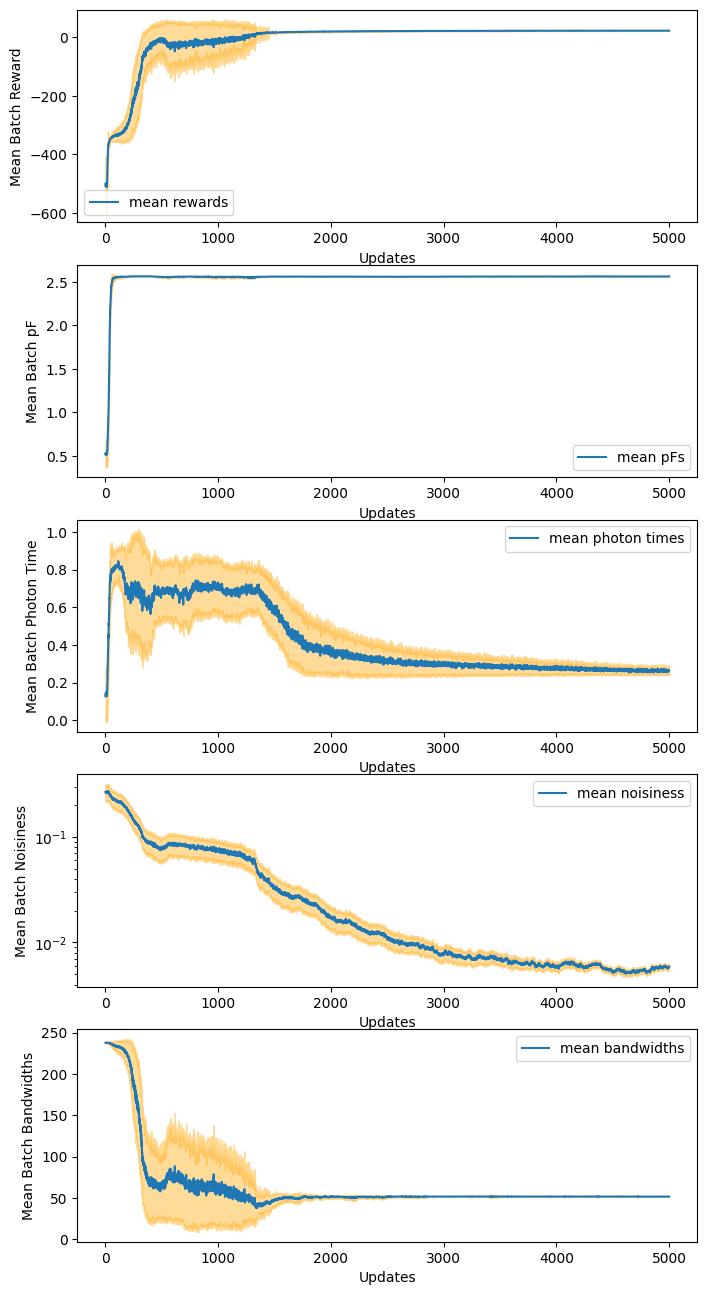

In [9]:
metric = single_result_k2["metrics"]

from utils import plot_learning

plot_learning(
    rewards=metric["reward"],
    max_pFs=metric["max pF"],
    photon_times=metric["photon time"],
    smoothnesses=metric["smoothness"],
    bandwidths=metric["bandwidth"]
)

In [12]:
import copy

config_2 = copy.deepcopy(config)
config_2["ENV_PARAMS"]["kappa"] = kappas[0]

config_2

{'LR': 0.0003,
 'NUM_ENVS': 256,
 'NUM_STEPS': 1,
 'NUM_UPDATES': 5000,
 'UPDATE_EPOCHS': 4,
 'NUM_MINIBATCHES': 4,
 'CLIP_EPS': 0.2,
 'VALUE_CLIP_EPS': 0.2,
 'ENT_COEF': 0.0,
 'VF_COEF': 0.5,
 'MAX_GRAD_NORM': 0.5,
 'ACTIVATION': 'relu6',
 'LAYER_SIZE': 64,
 'ENV_NAME': 'single_langevin_env',
 'ENV_PARAMS': {'kappa': Array(18., dtype=float64),
  'chi': 4.084070449666731,
  'kerr': 0.002,
  'time_coeff': 10.0,
  'snr_coeff': 10.0,
  'smoothness_coeff': 0.01,
  'smoothness_baseline_scale': 1.0,
  'apply_smoothing': True,
  'use_processed_action': False,
  'bandwidth': 50.0,
  'freq_relative_cutoff': 0.1,
  'bandwidth_coeff': 25.0,
  'apply_bandwidth_constraint': True,
  'n0': 43,
  'tau_0': 0.398,
  'res_amp_scaling': 2.3255813953488373,
  'nR': 0.01,
  'snr_scale_factor': 1.9,
  'gamma_I': 0.007142857142857143,
  'photon_gamma': 0.0006666666666666666,
  'num_t1': 5.0,
  'init_fid': 0.9999,
  'photon_weight': 4.0,
  'standard_fid': 0.99,
  'shot_noise_std': 0.01},
 'ANNEAL_LR': False,
 

In [13]:
single_train_kappa_1 = jit(PPO_Clipped_make_train(config_2), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_k1 = single_train_kappa_1(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -243.141
max pF: 2.575
max photon: 35.838
photon time: 0.7991
smoothness: 0.24895099999999998
bandwidth: 208.776
global update: 200
reward: -180.108
max pF: 2.581
max photon: 42.504
photon time: 0.6919000000000001
smoothness: 0.18420599999999998
bandwidth: 182.292
global update: 300
reward: -30.106
max pF: 2.582
max photon: 47.818
photon time: 0.776
smoothness: 0.102405
bandwidth: 63.205
global update: 400
reward: -13.183
max pF: 2.58
max photon: 43.062
photon time: 0.7893
smoothness: 0.098517
bandwidth: 70.373
global update: 500
reward: -27.177
max pF: 2.579
max photon: 40.699
photon time: 0.7774000000000001
smoothness: 0.09967799999999999
bandwidth: 85.044
global update: 600
reward: -23.432000000000002
max pF: 2.581
max photon: 41.53
photon time: 0.7853
smoothness: 0.094882
bandwidth: 77.778
global update: 700
reward: -10.625
max pF: 2.58
max photon: 40.58
photon time: 0.8271000000000001
smoothness: 0.09352099999999999
bandwid

In [23]:
config_3 = copy.deepcopy(config)
config_3["ENV_PARAMS"]["kappa"] = kappas[2]
config_3["ENV_PARAMS"]["num_t1"] = 7.0

config_3

{'LR': 0.0003,
 'NUM_ENVS': 256,
 'NUM_STEPS': 1,
 'NUM_UPDATES': 5000,
 'UPDATE_EPOCHS': 4,
 'NUM_MINIBATCHES': 4,
 'CLIP_EPS': 0.2,
 'VALUE_CLIP_EPS': 0.2,
 'ENT_COEF': 0.0,
 'VF_COEF': 0.5,
 'MAX_GRAD_NORM': 0.5,
 'ACTIVATION': 'relu6',
 'LAYER_SIZE': 64,
 'ENV_NAME': 'single_langevin_env',
 'ENV_PARAMS': {'kappa': Array(22., dtype=float64),
  'chi': 4.084070449666731,
  'kerr': 0.002,
  'time_coeff': 10.0,
  'snr_coeff': 10.0,
  'smoothness_coeff': 0.01,
  'smoothness_baseline_scale': 1.0,
  'apply_smoothing': True,
  'use_processed_action': False,
  'bandwidth': 50.0,
  'freq_relative_cutoff': 0.1,
  'bandwidth_coeff': 25.0,
  'apply_bandwidth_constraint': True,
  'n0': 43,
  'tau_0': 0.398,
  'res_amp_scaling': 2.3255813953488373,
  'nR': 0.01,
  'snr_scale_factor': 1.9,
  'gamma_I': 0.007142857142857143,
  'photon_gamma': 0.0006666666666666666,
  'num_t1': 7.0,
  'init_fid': 0.9999,
  'photon_weight': 4.0,
  'standard_fid': 0.99,
  'shot_noise_std': 0.01},
 'ANNEAL_LR': False,
 

In [24]:
single_train_kappa_3 = jit(PPO_Clipped_make_train(config_3), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_k3 = single_train_kappa_3(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -168.199
max pF: 2.512
max photon: 33.37
photon time: 0.40090000000000003
smoothness: 0.308726
bandwidth: 184.614
global update: 200
reward: -163.292
max pF: 2.532
max photon: 36.386
photon time: 0.4499
smoothness: 0.289171
bandwidth: 181.75300000000001
global update: 300
reward: -118.88
max pF: 2.544
max photon: 45.388
photon time: 0.7105
smoothness: 0.20898599999999998
bandwidth: 156.136
global update: 400
reward: -54.317
max pF: 2.549
max photon: 53.497
photon time: 0.7653000000000001
smoothness: 0.136657
bandwidth: 96.672
global update: 500
reward: -33.795
max pF: 2.544
max photon: 46.869
photon time: 0.7425
smoothness: 0.115281
bandwidth: 89.002
global update: 600
reward: -30.156000000000002
max pF: 2.543
max photon: 43.511
photon time: 0.7327
smoothness: 0.11873399999999999
bandwidth: 88.47800000000001
global update: 700
reward: -24.833000000000002
max pF: 2.544
max photon: 44.11
photon time: 0.7561
smoothness: 0.113820999

In [36]:
metric_k1 = single_result_k1["metrics"]
metric_k2 = single_result_k2["metrics"]
metric_k3 = single_result_k3["metrics"]

actions_k1 = metric_k1["action"]
actions_k2 = metric_k2["action"]
actions_k3 = metric_k3["action"]

photon_times_k1 = metric_k1["photon time"][-1, 0]
photon_times_k2 = metric_k2["photon time"][-1, 0]
photon_times_k3 = metric_k3["photon time"][-1, 0]

In [37]:
from utils import photon_env_dicts

env = photon_env_dicts()[config["ENV_NAME"]](**env_config)

In [38]:
raw_final_action_k1 = actions_k1[-1, 0]
raw_final_action_k2 = actions_k2[-1, 0]
raw_final_action_k3 = actions_k3[-1, 0]

ts_mod = env.ts_action / param_error_array[2] / (config["ENV_PARAMS"]["num_t1"]) * config_3["ENV_PARAMS"]["num_t1"]

raw_smooth_action_k1 = env.prepare_action(raw_final_action_k1) * jnp.heaviside(photon_times_k1 - env.ts_action / param_error_array[0], 0.)
raw_smooth_action_k2 = env.prepare_action(raw_final_action_k2) * jnp.heaviside(photon_times_k2 - env.ts_action / param_error_array[0], 0.)
raw_smooth_action_k3 = env.prepare_action(raw_final_action_k3) * jnp.heaviside(photon_times_k3 - ts_mod, 0.)

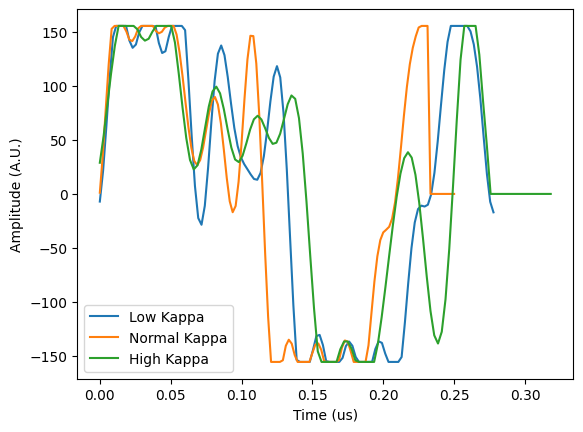

In [39]:
# Comparing Kappa Waveforms

# Divide Time by Error Percentage because it corresponds to change in timescale
# Amplitude can be left as it is because we would deal with normalized waveforms
# So absolute values aren't relevant, only the waveform shapes

plt.plot(env.ts_action / param_error_array[0], -raw_smooth_action_k1, label='Low Kappa')
plt.plot(env.ts_action / param_error_array[1], -raw_smooth_action_k2, label='Normal Kappa')
plt.plot(ts_mod, -raw_smooth_action_k3, label='High Kappa')
plt.legend()
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.show()

## Chi Variance

In [ ]:
config_4 = copy.deepcopy(config)
config_4["ENV_PARAMS"]["chi"] = chis[0]

config_4

In [ ]:
single_train_chi_1 = jit(PPO_Clipped_make_train(config_4), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_c1 = single_train_chi_1(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

In [ ]:
config_5 = copy.deepcopy(config)
config_5["ENV_PARAMS"]["chi"] = chis[1]

config_5

In [ ]:
single_train_chi_2 = jit(PPO_Clipped_make_train(config_5), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_c2 = single_train_chi_2(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

In [ ]:
config_6 = copy.deepcopy(config)
config_6["ENV_PARAMS"]["chi"] = chis[2]

config_6

In [ ]:
single_train_chi_3 = jit(PPO_Clipped_make_train(config_6), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_c3 = single_train_chi_3(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

In [ ]:
metric_c1 = single_result_c1["metrics"]
metric_c2 = single_result_c2["metrics"]
metric_c3 = single_result_c3["metrics"]

actions_c1 = metric_c1["action"]
actions_c2 = metric_c2["action"]
actions_c3 = metric_c3["action"]

In [ ]:
raw_final_action_c1 = actions_c1[-1, 0]
raw_final_action_c2 = actions_c2[-1, 0]
raw_final_action_c3 = actions_c3[-1, 0]

raw_smooth_action_c1 = env.prepare_action(raw_final_action_c1)
raw_smooth_action_c2 = env.prepare_action(raw_final_action_c2)
raw_smooth_action_c3 = env.prepare_action(raw_final_action_c3)

In [ ]:
# Comparing Chi Waveforms

plt.plot(env.ts_action, raw_smooth_action_c1, label='Low Chi')
plt.plot(env.ts_action, raw_smooth_action_c2, label='Normal Chi')
plt.plot(env.ts_action, raw_smooth_action_c3, label='High Chi')
plt.legend()
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.show()